In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import math
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
from tqdm import tqdm
import sys

from astropy.coordinates import Distance
import bilby
from gwBackground import *
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator

from constants import *
import equations
import redshiftPrior

In [2]:
# Plot formatting
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 9
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]  

In [3]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Frequency Parameters
fmax = 3000
fref = 25

# Data Simulation Parameters
T_obs = (1/365.25/24) # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
N_segs = 1 # number of data segments to generate
fs = 2048 # sampling rate (in Hz)
num_iterations = 12 # number of iterations to average Omega(f) over

In [8]:
# Standard Prior Dictionary
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['redshift'] = redshiftPrior.PowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')

16:43 bilby INFO    : Using aligned spin prior
16:43 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [9]:
# Calculate number of injections
zs, p_dz = priors['redshift']._get_redshift_arrays()
N = redshiftPrior.calculate_num_injections(T_obs, zs, p_dz)
print(N)

8.182232378418727 Mpc3 / sr


Total number of injections: 5


16:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:43:59.646 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 5 injections
100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 113.17it/s]
2023-08-21 16:43:59.710 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:43:59.711 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:43:59.711 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.39e-08


Total number of injections: 9


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:02.629 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 9 injections
100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 245.24it/s]
2023-08-21 16:44:02.668 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:02.668 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:02.668 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.76e-09


Total number of injections: 4


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:05.538 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 4 injections
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 222.47it/s]
2023-08-21 16:44:05.558 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:05.559 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:05.559 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=5.31e-09


Total number of injections: 8


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:08.319 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 8 injections
100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 238.25it/s]
2023-08-21 16:44:08.354 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:08.354 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:08.355 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.39e-09


Total number of injections: 14


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:11.131 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 14 injections
100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 246.09it/s]
2023-08-21 16:44:11.189 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:11.190 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:11.190 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=2.80e-09


Total number of injections: 11


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:13.947 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 11 injections
100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 251.48it/s]
2023-08-21 16:44:13.992 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:13.993 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:13.993 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=2.30e-09


Total number of injections: 8


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:16.758 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 8 injections
100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 217.58it/s]
2023-08-21 16:44:16.797 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:16.797 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:16.798 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=2.39e-09


Total number of injections: 6


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:19.559 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 6 injections
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 249.39it/s]
2023-08-21 16:44:19.584 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:19.585 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:19.585 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.90e-09


Total number of injections: 17


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:22.349 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 17 injections
100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 248.98it/s]
2023-08-21 16:44:22.419 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:22.419 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:22.420 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=2.03e-08


Total number of injections: 9


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:25.163 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 9 injections
100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 258.84it/s]
2023-08-21 16:44:25.199 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:25.199 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:25.200 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.54e-09


Total number of injections: 8


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:27.945 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 8 injections
100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 258.20it/s]
2023-08-21 16:44:27.978 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:27.978 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:27.979 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.03e-09


Total number of injections: 12


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:30.722 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 12 injections
100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 256.15it/s]
2023-08-21 16:44:30.771 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:30.771 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:30.772 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.37e-09


Omega_ref at 25 Hz: 4.66e-09


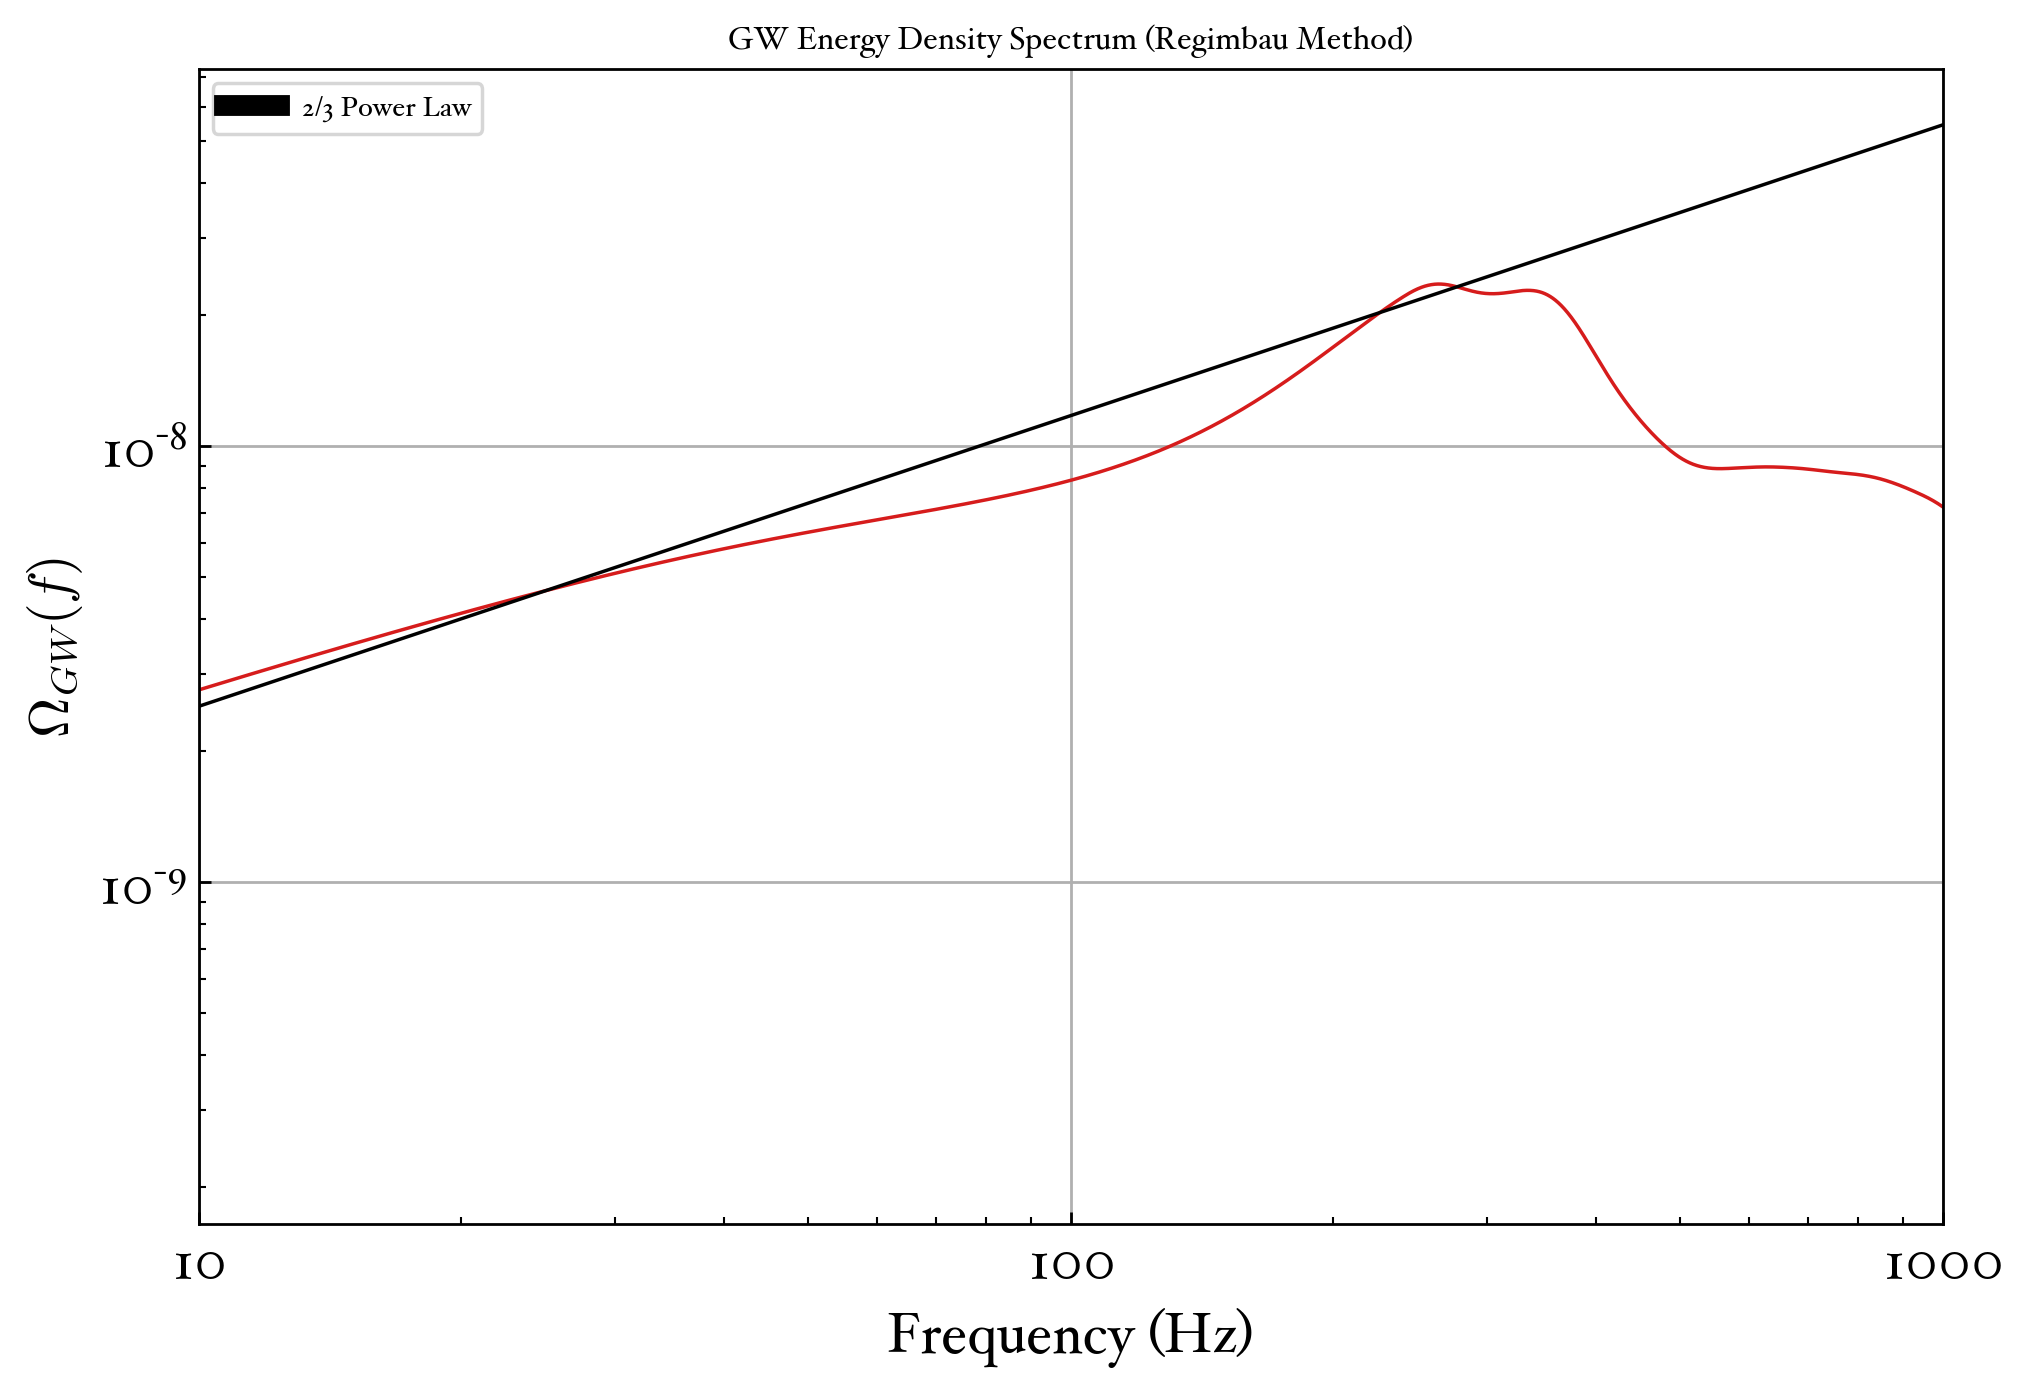

In [11]:
# Regimbau Method
total_freqs_AR = []
total_OmegaGW_AR = []
for iteration in range(num_iterations):
    # Create injections
    N_inj = np.random.poisson(N.value)
    injections = priors.sample(N_inj)
    injections["signal_type"] = 'CBC'
    print('Total number of injections: ' + str(N_inj))
    
    import json
    with open("test_CBC_injection_dict.json", "w") as outfile:
        json.dump(injections, outfile, indent=2, cls=bilby.core.result.BilbyJsonEncoder
    )
    
    # Initialize interferometers
    ifo_H1 = bilby.gw.detector.get_empty_interferometer('H1')
    ifo_L1 = bilby.gw.detector.get_empty_interferometer('L1')

    ifo_list = [ifo_H1, ifo_L1]

    for ifo in ifo_list: # iterate over interferometers
        ifo.duration = duration
        ifo.sampling_frequency = fs
        ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity\
        (ifo.frequency_array, 1e-3*np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))
    
    # Simulate data
    simulator_cbc = Simulator(ifo_list, N_segs, duration=duration, injection_dict=injections,
                                           sampling_frequency=fs, no_noise=False)
    freqs_AR, OmegaGW_AR = simulator_cbc.compute_injected_Omega(return_spectrum=True, waveform_duration=4)
    
    if iteration == 0:
        total_freqs_AR = freqs_AR
        total_OmegaGW_AR = OmegaGW_AR
    else:
        for freq in range(len(freqs_AR)):
            total_freqs_AR[freq] += freqs_AR[freq]
            total_OmegaGW_AR[freq] += OmegaGW_AR[freq]
    
for freq in range(len(total_freqs_AR)):
    total_freqs_AR[freq] /= num_iterations
    total_OmegaGW_AR[freq] /= num_iterations

# Find OmegaGW(fref)
fref_approx_AR = 100
fref_approx_index_AR = 0
for i in range(len(freqs_AR)):
    if(np.absolute(freqs_AR[i] - fref) < fref_approx_AR):
        fref_approx_AR = np.absolute(freqs_AR[i] - fref)
        fref_approx_index_AR = i
Omega_ref_AR = total_OmegaGW_AR[fref_approx_index_AR]
    
# Plot spectrum
plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.loglog(total_freqs_AR, total_OmegaGW_AR, color='#d61c1c')
ax.loglog(total_freqs_AR, Omega_ref_AR*(total_freqs_AR/fref)**(2/3), label='2/3 Power Law', color='#000000')

ax.set_xlim(10, 1000)
ax.set_title(r'GW Energy Density Spectrum (Regimbau Method)')
ax.set_xlabel(r'Frequency (Hz)', fontsize=16)
ax.set_ylabel(r'$\Omega_{GW}(f)$', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend()

print('Omega_ref at 25 Hz: ' + format(Omega_ref_AR, '.2e'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total number of injections: 6


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:34.062 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 6 injections
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 237.15it/s]
2023-08-21 16:44:34.088 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:34.089 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:34.089 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=9.70e-10


Total number of injections: 10


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:36.855 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 10 injections
100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 238.71it/s]
2023-08-21 16:44:36.898 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:36.899 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:36.899 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=3.52e-09


Total number of injections: 1


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:39.689 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 1 injections
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 202.59it/s]
2023-08-21 16:44:39.696 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:39.696 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:39.697 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=7.41e-10


Total number of injections: 12


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:42.482 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 12 injections
100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 259.23it/s]
2023-08-21 16:44:42.530 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:42.530 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:42.530 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.90e-08


Total number of injections: 8


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:45.331 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 8 injections
100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 248.50it/s]
2023-08-21 16:44:45.365 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:45.365 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:45.365 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=5.50e-09


Total number of injections: 6


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:48.163 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 6 injections
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 248.04it/s]
2023-08-21 16:44:48.189 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:48.190 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:48.190 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.30e-08


Total number of injections: 8


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:50.973 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 8 injections
100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 245.90it/s]
2023-08-21 16:44:51.007 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:51.007 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:51.008 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.24e-09


Total number of injections: 9


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:53.780 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 9 injections
100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 243.94it/s]
2023-08-21 16:44:53.819 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:53.819 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:53.820 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=3.97e-08


Total number of injections: 8


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:56.590 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 8 injections
100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 241.10it/s]
2023-08-21 16:44:56.625 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:56.625 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:56.625 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=2.59e-09


Total number of injections: 7


16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:44:59.397 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 7 injections
100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 261.31it/s]
2023-08-21 16:44:59.426 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:44:59.426 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:44:59.426 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=3.25e-09


Total number of injections: 6


16:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:45:02.199 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 6 injections
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 252.81it/s]
2023-08-21 16:45:02.224 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:45:02.225 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:45:02.225 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.07e-08


Total number of injections: 6


16:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-21 16:45:04.994 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 6 injections
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 246.57it/s]
2023-08-21 16:45:05.020 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-21 16:45:05.020 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-21 16:45:05.021 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.25e-09


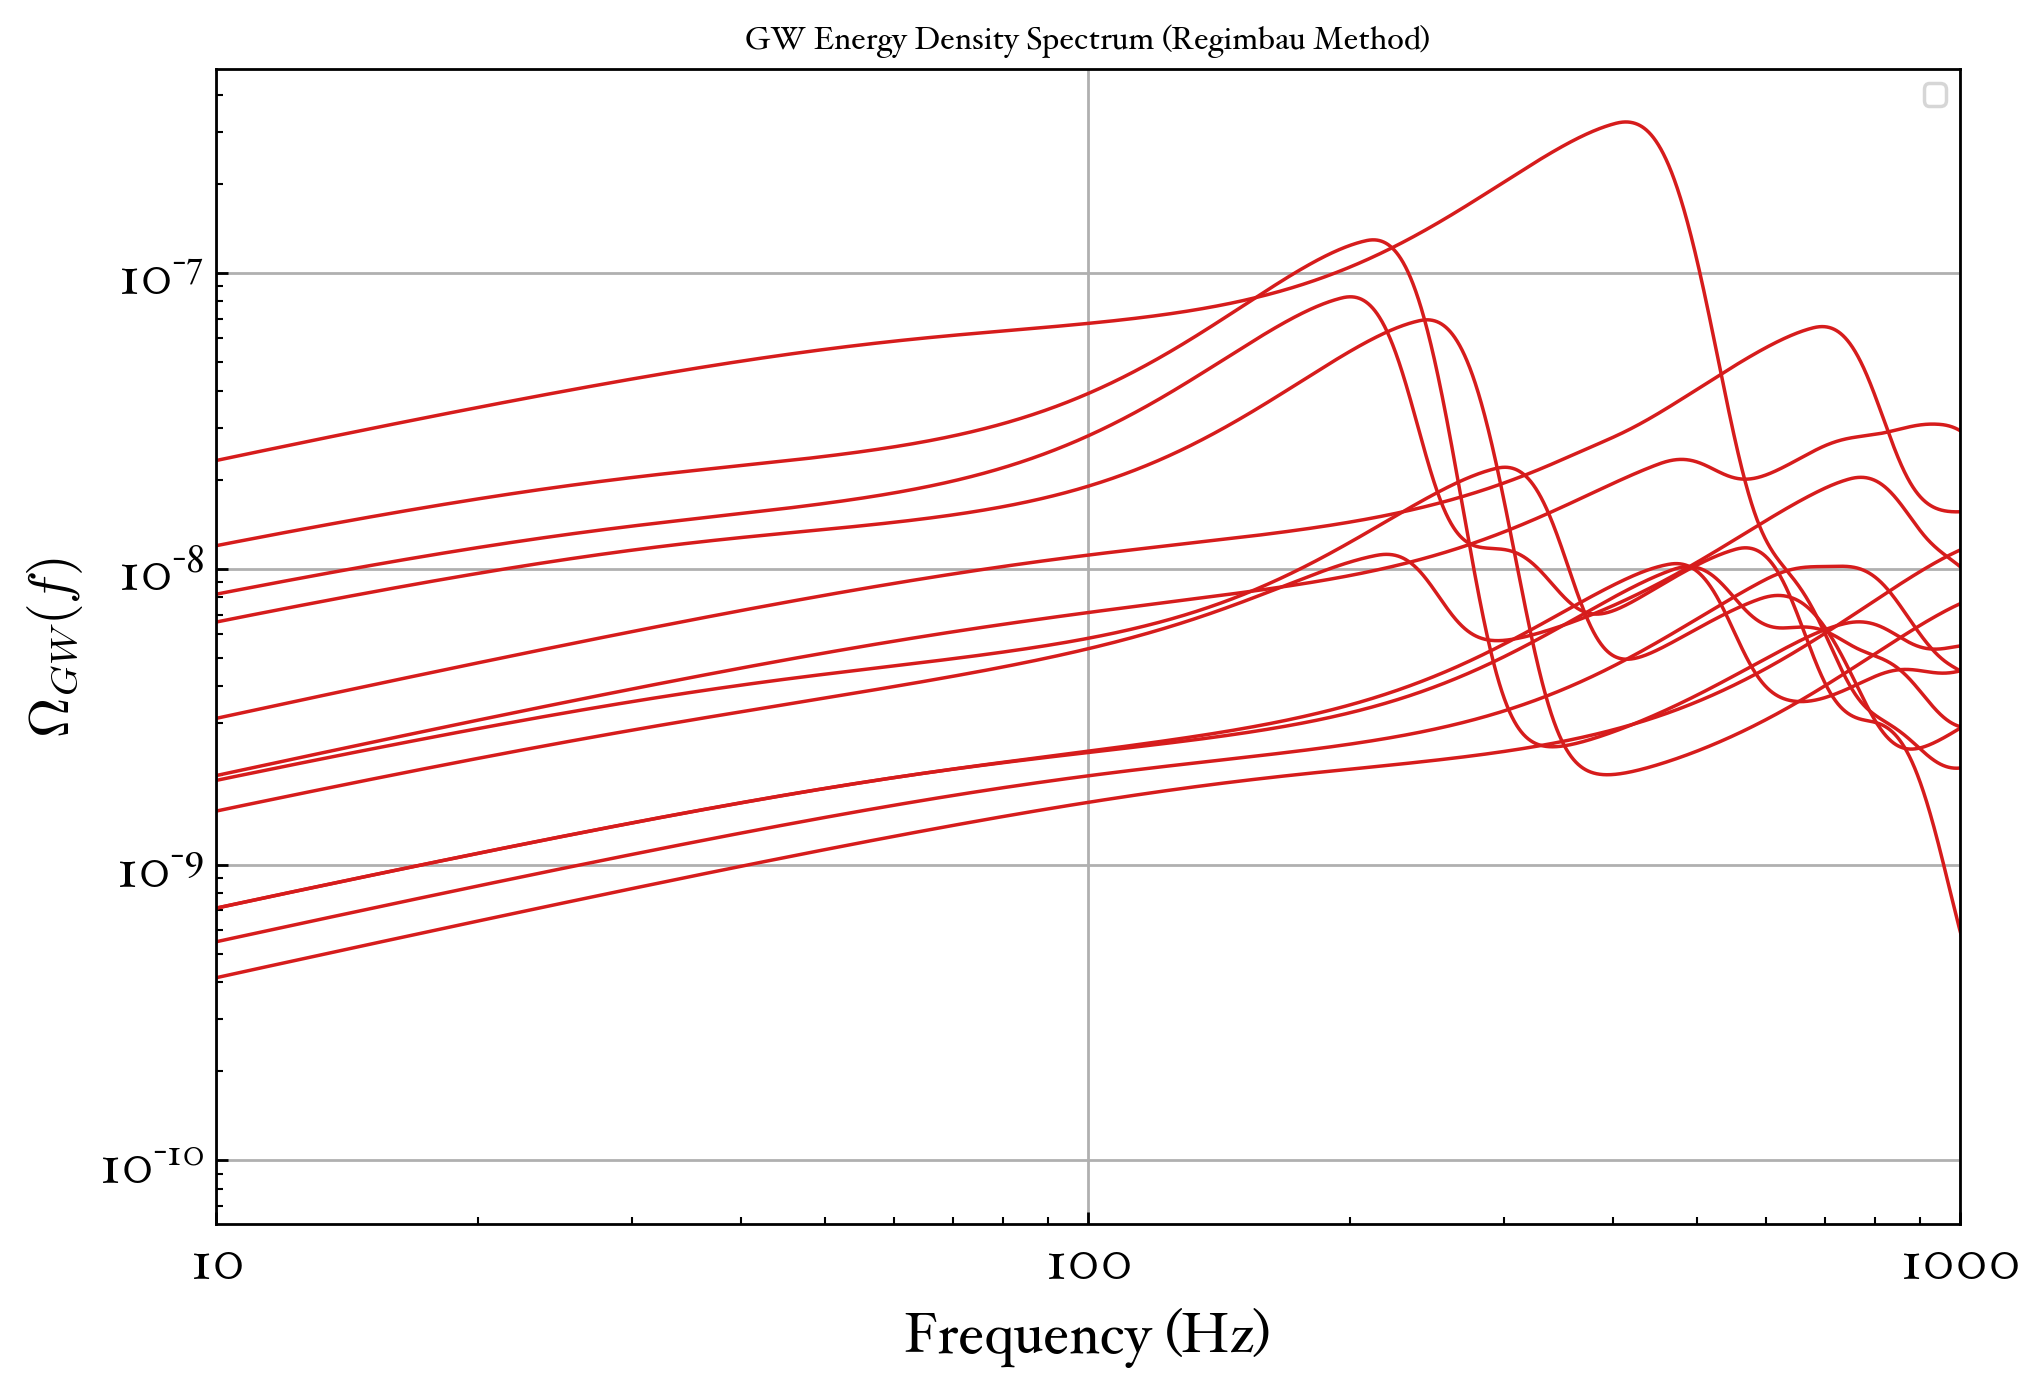

In [12]:
# Regimbau Method
# Plot spectrum
plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.set_xlim(10, 1000)
ax.set_title(r'GW Energy Density Spectrum (Regimbau Method)')
ax.set_xlabel(r'Frequency (Hz)', fontsize=16)
ax.set_ylabel(r'$\Omega_{GW}(f)$', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend()

for iteration in range(num_iterations):
    # Create injections
    N_inj = np.random.poisson(N.value)
    injections = priors.sample(N_inj)
    injections["signal_type"] = 'CBC'
    print('Total number of injections: ' + str(N_inj))
    
    import json
    with open("test_CBC_injection_dict.json", "w") as outfile:
        json.dump(injections, outfile, indent=2, cls=bilby.core.result.BilbyJsonEncoder
    )
    
    # Initialize interferometers
    ifo_H1 = bilby.gw.detector.get_empty_interferometer('H1')
    ifo_L1 = bilby.gw.detector.get_empty_interferometer('L1')

    ifo_list = [ifo_H1, ifo_L1]

    for ifo in ifo_list: # iterate over interferometers
        ifo.duration = duration
        ifo.sampling_frequency = fs
        ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity\
        (ifo.frequency_array, 1e-3*np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))
    
    # Simulate data
    simulator_cbc = Simulator(ifo_list, N_segs, duration=duration, injection_dict=injections,
                                           sampling_frequency=fs, no_noise=False)
    freqs_AR, OmegaGW_AR = simulator_cbc.compute_injected_Omega(return_spectrum=True, waveform_duration=4)
    ax.loglog(freqs_AR, OmegaGW_AR, color='#d61c1c')

[10.         10.32020097 10.65065481 10.99168981 11.34364479
 11.7068694  12.08172449 12.46858249 12.86782771 13.2798568
 13.70507911 14.14391707 14.59680667 15.06419784 15.54655492
 16.04435712 16.55809899 17.08829093 17.63545967 18.2001488
 18.78291933 19.38435024 20.00503902 20.64560231 21.3066765
 21.98891835 22.69300566 23.4196379  24.16953699 24.94344791
 25.74213953 26.56640534 27.41706423 28.29496129 29.2009687
 30.13598655 31.10094377 32.09679901 33.12454164 34.18519268
 35.27980587 36.40946869 37.57530341 38.77846828 40.0201586
 41.30160797 42.62408947 43.98891696 45.39744635 46.851077
 48.35125304 49.89946486 51.49725057 53.14619754 54.84794395
 56.60418045 58.41665181 60.28715868 62.21755936 64.20977165
 66.26577478 68.38761133 70.57738929 72.83728416 75.16954108
 77.57647709 80.06048342 82.62402788 85.26965729 88.        ]
[0.11363636 0.1274858  0.14133523 0.15518466 0.16903409
 0.18288352 0.19673295 0.21058239 0.22443182 0.23828125
 0.25213068 0.26598011 0.27982955 0.2936

/var/folders/ll/kr0d3dk97nscjzcx85rrjmz00000gn/T/ipykernel_12441/1330781980.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


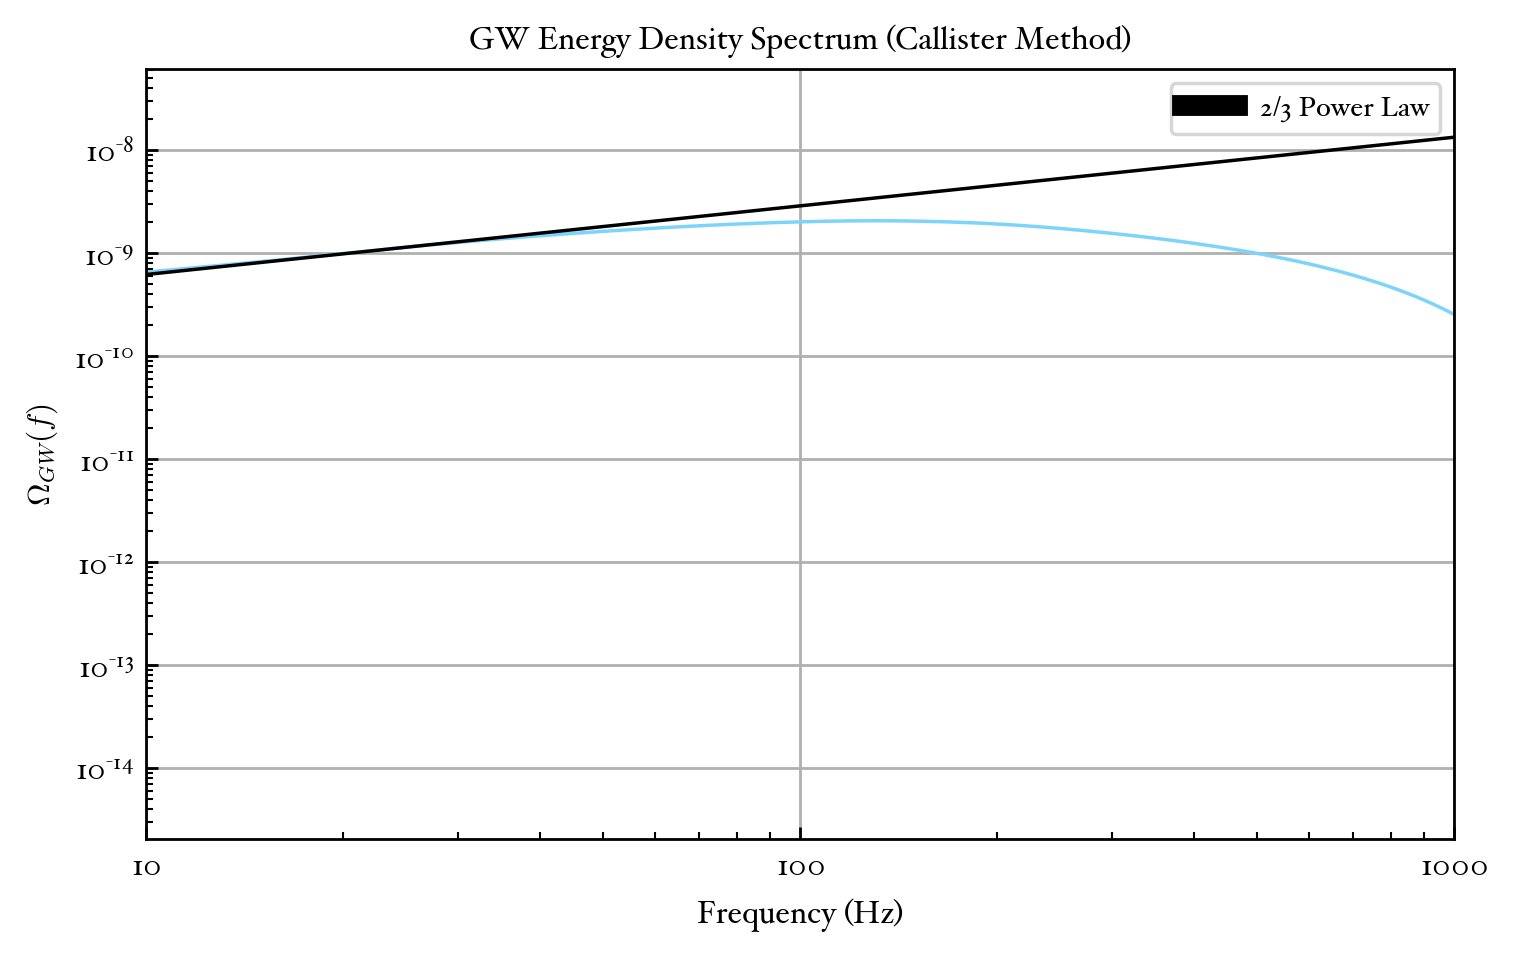

In [13]:
# Callister Method
# Set up OmegaGW object
inspiralOnly = False
m1_min = BBH_min
m1_max = BBH_max
m2_min = BBH_min
m2_max = BBH_max
minimum_component_mass = BBH_min
maximum_component_mass = BBH_max
omg = OmegaGW_BBH(minimum_component_mass, maximum_component_mass, zs)

# Calculate merger rate
mergerRate = equations.get_R_array(zs, alpha, beta, zp, R0)

# Calculate probability grid
# Priors defined in (m1, q) space
probs = np.empty((omg.m1s_2d.shape[0], omg.qs_2d.shape[1])) # initialize array
for i in range(omg.m1s_2d.shape[0]): # for each m1
    for j in range(omg.qs_2d.shape[1]): # for each q
        prob = priors.prob({'mass_1':omg.m1s_2d[i][j], 'mass_ratio':omg.qs_2d[i][j]}) # calculate probability
        probs[i][j] = prob # insert probability into probability array
probs = probs*(omg.Mtots_2d/(1. + omg.qs_2d)) # multiply by the Jacobian

# Limit probabilities to physical masses
probs[omg.m1s_2d < m1_min] = 0
probs[omg.m1s_2d > m1_max] = 0
probs[omg.m2s_2d < m2_min] = 0
probs[omg.m2s_2d > m2_max] = 0

# Normalize probabilities
probs /= np.sum(probs)
omg.probs = probs

# Calculate Omega(f)
freqs_TC = np.logspace(0, np.log10(fmax), 200)
OmegaGW_TC = omg.eval(R0, mergerRate, freqs_TC)

# Find OmegaGW(fref)
fref_approx_TC = 100
fref_approx_index_TC = 0
for i in range(len(freqs_TC)):
    if(np.absolute(freqs_TC[i] - fref) < fref_approx_TC):
        fref_approx_TC = np.absolute(freqs_TC[i] - fref)
        fref_approx_index_TC = i
Omega_ref_TC = OmegaGW_TC[fref_approx_index_TC]

# Plot
fig, ax = plt.subplots()
ax.loglog(freqs_TC, OmegaGW_TC, color='#7dd4fa')
ax.loglog(freqs_TC, Omega_ref_TC*(freqs_TC/fref)**(2/3), label='2/3 Power Law', color='#000000')
ax.set_title(r'GW Energy Density Spectrum (Callister Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
ax.legend()
fig.show()

/var/folders/ll/kr0d3dk97nscjzcx85rrjmz00000gn/T/ipykernel_12441/359215342.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


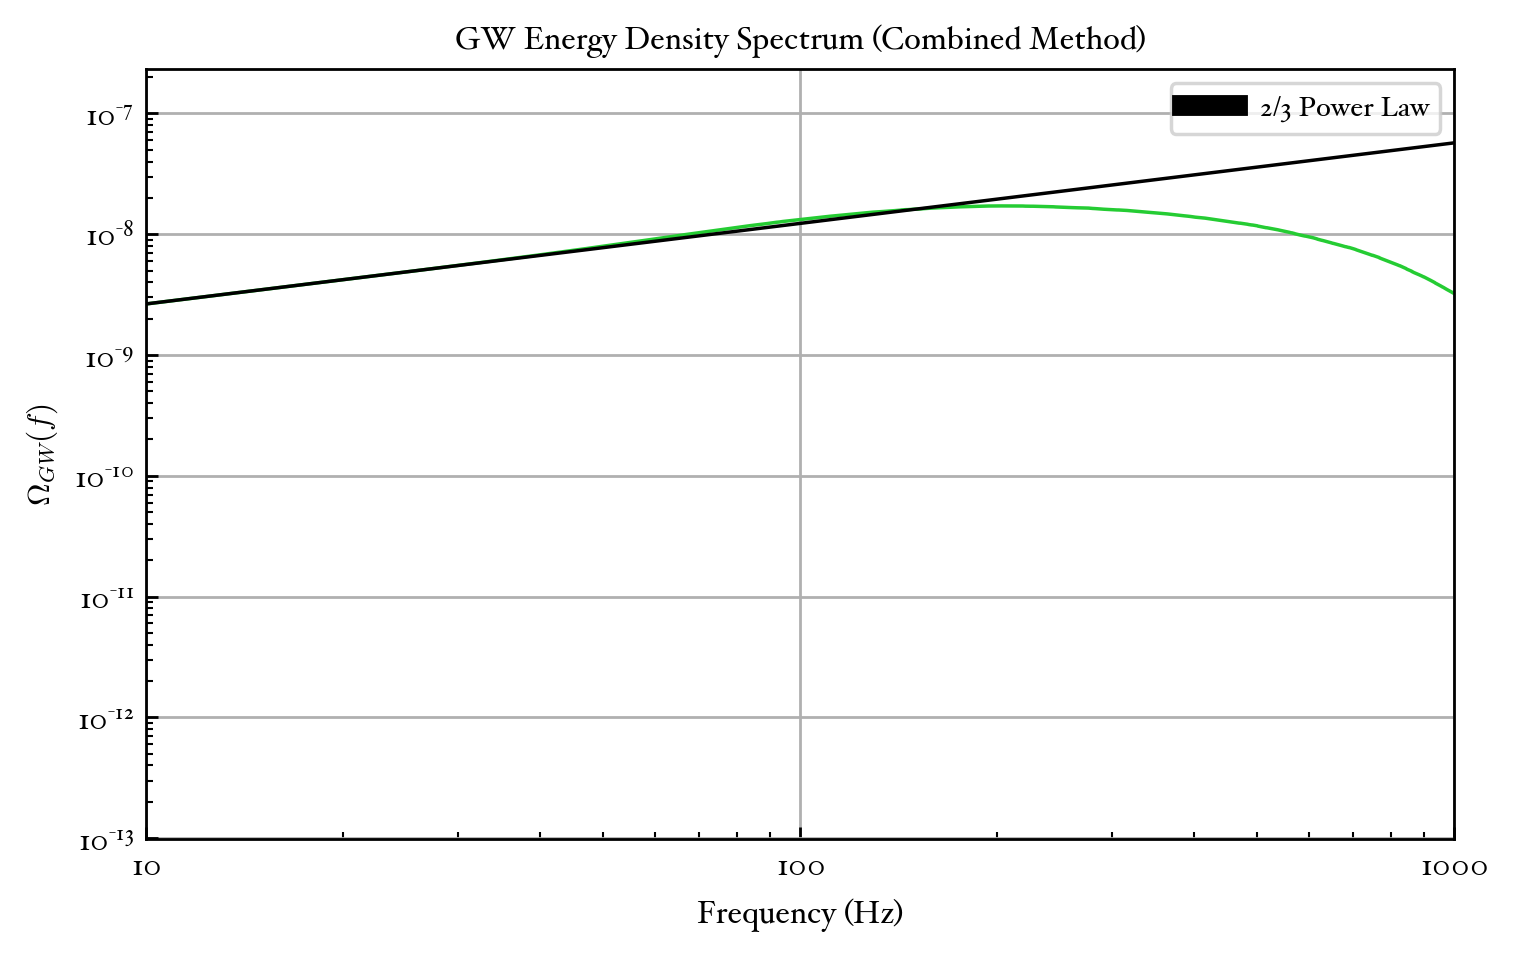

In [14]:
# Combined Method
total_freqs_CB = []
total_OmegaGW_CB = []
# total_Omega_ref_CB = 0
for iteration in range(num_iterations):
    # Determine number of injections
    N_inj = np.random.poisson(N.value)
    injections = priors.sample(N_inj)
    m1s = injections['mass_1']
    qs = injections['mass_ratio']
    m2s = []
    Mtots = [] # m1 + m2
    events = [] # array of chirp masses
    for i in range(len(injections['mass_1'])):
        m2s.append(equations.calculate_m2(m1s[i], qs[i]))
        Mtots.append(equations.calculate_Mtot(m1s[i], m2s[i]))
        events.append(equations.calculate_M(m1s[i], m2s[i]))

    # Calculate Omega(f)
    freqs_CB = []
    OmegaGW_values_CB = []

    for i in range(1, fmax):
        f = i # frequency (in Hz)

        # Equation from Renzini et al. 2022.
        # Calculate the GW energy density by summing the spectral energy density from individual BBH events across redshift space.
        def integrand(z):
            f_ref = f*(1 + z)
            r = equations.R_SI(alpha, beta, z, zp, R0)
            ave_dedf = equations.ave_dEdf_SI(f_ref, Mtots, events)
            h = equations.Hubble_rate_SI(z, H0, omegaR, omegaM, omegak, omegaL)
            return r*ave_dedf/((1 + z)*h)

        integral = scipy.integrate.quad(integrand, 0, z_max)
        OmegaGW = f/equations.pc_SI(H0)*integral[0]
        freqs_CB.append(f)
        OmegaGW_values_CB.append(OmegaGW)
    
    if iteration == 0:
        total_freqs_CB = freqs_CB
        total_OmegaGW_CB = OmegaGW_values_CB
    else:
        for freq in range(len(freqs_CB)):
            total_freqs_CB[freq] += freqs_CB[freq]
            total_OmegaGW_CB[freq] += OmegaGW_values_CB[freq]
    
for i in range(len(total_freqs_CB)):
    total_freqs_CB[i] /= num_iterations
    total_OmegaGW_CB[i] /= num_iterations

# Find OmegaGW(fref)
fref_approx_CB = 100
fref_approx_index_CB = 0
for i in range(len(freqs_CB)):
    if(np.absolute(freqs_CB[i] - fref) < fref_approx_CB):
        fref_approx_CB = np.absolute(freqs_CB[i] - fref)
        fref_approx_index_CB = i
Omega_ref_CB = total_OmegaGW_CB[fref_approx_index_CB]

# Plot
fig, ax = plt.subplots()
ax.loglog(total_freqs_CB, total_OmegaGW_CB, color='#25cc33')
ax.loglog(total_freqs_CB, Omega_ref_CB*(np.array(total_freqs_CB)/fref)**(2/3), label='2/3 Power Law', color='#000000')
ax.set_title(r'GW Energy Density Spectrum (Combined Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
ax.legend()
fig.show()

/var/folders/ll/kr0d3dk97nscjzcx85rrjmz00000gn/T/ipykernel_12441/1985773039.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


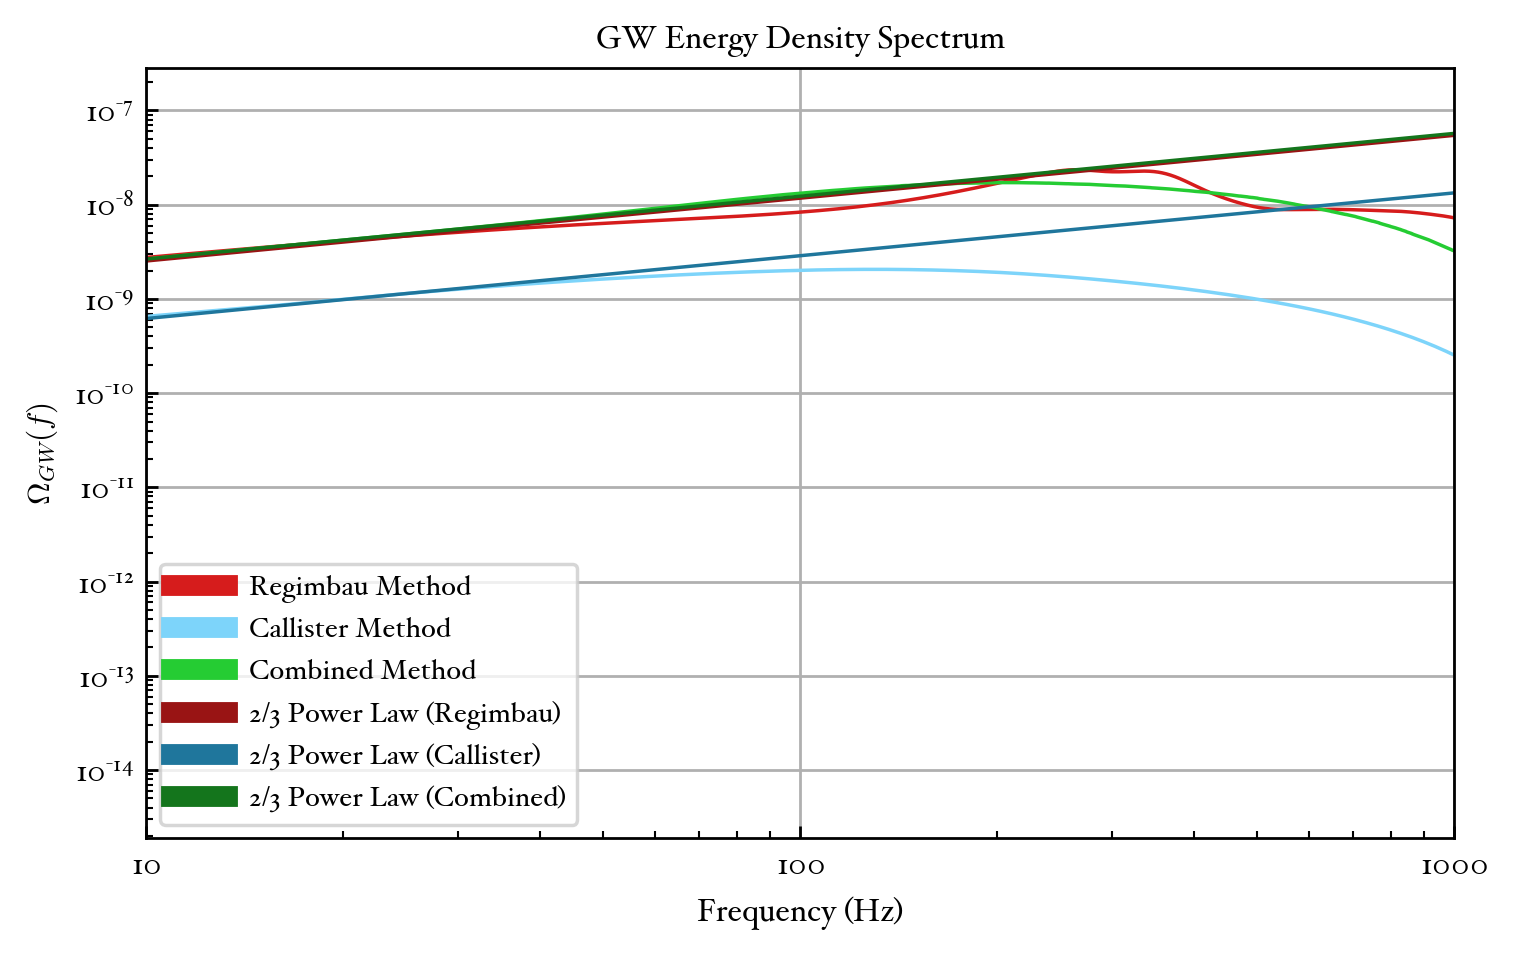

In [15]:
fig, ax = plt.subplots()
ax.loglog(total_freqs_AR, total_OmegaGW_AR, color='#d61c1c', label='Regimbau Method')
ax.loglog(freqs_TC, OmegaGW_TC, color='#7dd4fa', label='Callister Method')
ax.loglog(total_freqs_CB, total_OmegaGW_CB, color='#25cc33', label='Combined Method')
ax.loglog(total_freqs_AR, Omega_ref_AR*(total_freqs_AR/fref)**(2/3), label='2/3 Power Law (Regimbau)', color='#991414')
ax.loglog(freqs_TC, Omega_ref_TC*(freqs_TC/fref)**(2/3), label='2/3 Power Law (Callister)', color='#1f769c')
ax.loglog(freqs_CB, Omega_ref_CB*(np.array(freqs_CB)/fref)**(2/3), label='2/3 Power Law (Combined)', color='#14751c')
ax.set_title(r'GW Energy Density Spectrum')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
ax.legend()
fig.show()